## This notebook is about implementing a Density-Based Spatial Clustering of Applications with Noise(DBSCAN) algorithm

In [1]:
#Import statements 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

sns.set_theme()

## Create the dataset

<Axes: xlabel='dim1', ylabel='dim2'>

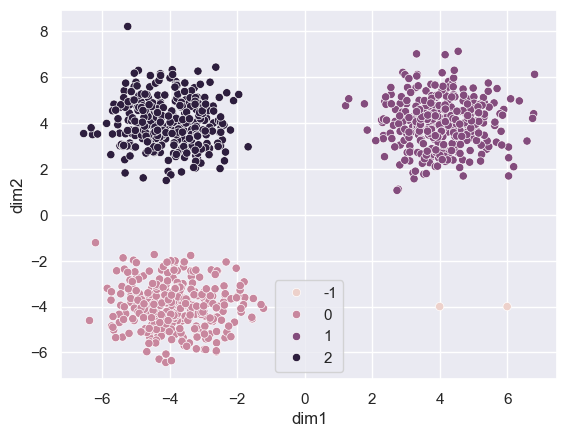

In [2]:
# Create dataset
X, y = make_blobs(n_samples=1000, n_features=2, random_state=4, centers=[[-4,-4], [4,4], [-4,4]])

# Add two outliers
X = np.vstack([X, np.array([[4,-4], [6,-4]])])
y = np.concatenate([y, np.array([-1,-1])])

# Convert to data frame
X_df = pd.DataFrame(X, columns=['dim1', 'dim2'])

# Plot the blobs
sns.scatterplot(X_df, x='dim1', y='dim2', hue=y)

## Radius neighbors


In [3]:
nearest_neigh = NearestNeighbors()
nearest_neigh = nearest_neigh.fit(X)

In [4]:
nearest_neigh

NearestNeighbors()

In [8]:
example_data_point_id = 0
np.expand_dims(X[example_data_point_id], axis=0)

array([[-3.61771896, -3.59530662]])

In [9]:
example_data_point_id_ = 3
np.expand_dims(X[example_data_point_id_], axis=0)

array([[-4.46094707, -1.730428  ]])

In [10]:
nearest_neigh.radius_neighbors(
    np.expand_dims(X[example_data_point_id], axis=0), 
    radius=0.2, 
    return_distance=True
)

(array([array([0.15527816, 0.18238293, 0.14078337, 0.16316669, 0.16469154,
               0.12522063, 0.        , 0.08413493])                       ],
       dtype=object),
 array([array([180,  15, 345, 113, 136, 839,   0, 742])], dtype=object))

In [11]:
nearest_neigh.radius_neighbors(
    X[[0,1], :], 
    radius=0.2, 
    return_distance=False
)

array([array([180,  15, 345, 113, 136, 839,   0, 742]),
       array([  1, 280,  33, 973, 391, 998, 926])], dtype=object)

## DBSCAN Implementation

In [12]:
# Set main parameters
eps = 1
min_samples = 5

In [13]:
# Create dataframe to store results
point_df = pd.DataFrame(index=X_df.index)

point_df['cluster'] = None
point_df['unvisited'] = True
point_df['core'] = False
point_df['border'] = False


point_df.head()

,cluster,unvisited,core,border
0,None,True,False,False
1,None,True,False,False
2,None,True,False,False
3,None,True,False,False
4,None,True,False,False


In [14]:
# Id of first cluster is 0
current_cluster = 0

# Outter loop iterates through clusters
while True:
    
    # Check if there are unvisited points left
    if point_df['unvisited'].sum()==0:
        break
    
    # Get first available unvisited point
    curr_point = point_df[point_df['unvisited']].index[0]
    
    # Get neighbors of selected point within eps radius
    # cluster_points set will be used to add cluster candidates
    cluster_points = set(
        nearest_neigh.radius_neighbors(
            np.expand_dims(X[curr_point], axis=0), 
            radius=eps, 
            return_distance=False
            )[0]
        )
    
    # If point has enough neighbors within eps radius
    # then start building the cluster
    if len(cluster_points) >= min_samples:
        
        # Assign cluster id to the current data point
        point_df.loc[curr_point, 'cluster'] = current_cluster
        point_df.loc[curr_point, 'core'] = True
        
        cluster_points = {point for point in cluster_points if point_df.loc[point, 'unvisited']}
        
        # Cluster is built in this loop
        while True:
            
            # Select one of the candiate points
            curr_point = cluster_points.pop()
            
            point_df.loc[curr_point, 'unvisited'] = False
            point_df.loc[curr_point, 'cluster'] = current_cluster
            
            # Get all neighbors of curr_point that are within eps distance
            curr_cluster_points = set(
                nearest_neigh.radius_neighbors(
                    np.expand_dims(X[curr_point], axis=0), 
                    radius=eps,
                    return_distance=False
                    )[0]
                )
            
            # If number of obtained neighbors is not sufficient
            # then data point is border data point
            if len(curr_cluster_points) < min_samples:
                
                point_df.loc[curr_point, 'border'] = True

            # If point has sufficient neighborhood:
            else:
                
                point_df.loc[curr_point, 'core'] = True
                
                # Add point to the current cluster
                # Get all of the point neighbors within eps distance
                add_points = {point for point in curr_cluster_points if point_df.loc[point, 'unvisited']}
                
                # Add neighbors to the current cluster candidates
                cluster_points.update(add_points)
                
            # If no cluster candidates remain, then
            # break the loop and proceed to the next
            # cluster
            if len(cluster_points) == 0:
                break
        
        # Incremen cluster ID
        current_cluster+=1
        
    else:
        
        # If selected point does not have sufficient
        # neighborhood then mark it as visited and continue
        point_df.loc[curr_point, 'unvisited'] = False


The provided code implements a clustering algorithm similar to **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise).

---

### **Key Parameters**:
1. **`eps`**: Defines the radius of the neighborhood for a point. Points within this distance are considered neighbors.
2. **`min_samples`**: The minimum number of points (including the point itself) required to form a cluster.
3. **Dataframe `point_df`**:
   - Tracks the state of each data point.
   - **`cluster`**: Cluster ID assigned to the point (initially `None`).
   - **`unvisited`**: Boolean flag indicating whether the point has been visited.
   - **`core`**: Boolean flag indicating whether the point is a core point.
   - **`border`**: Boolean flag indicating whether the point is a border point.

---

### **Code Walkthrough**:

#### 1. **Outer Loop: Iterate Over Clusters**
   ```python
   while True:
       if point_df['unvisited'].sum() == 0:
           break
   ```
   - This loop continues until all points are visited (`unvisited` becomes `False` for all points).

---

#### 2. **Select an Unvisited Point**:
   ```python
   curr_point = point_df[point_df['unvisited']].index[0]
   ```
   - Selects the first unvisited point to process.

---

#### 3. **Find Neighbors Within `eps` Radius**:
   ```python
   cluster_points = set(
       nearest_neigh.radius_neighbors(
           np.expand_dims(X[curr_point], axis=0), 
           radius=eps, 
           return_distance=False
       )[0]
   )
   ```
   - Finds all neighbors of the current point (`curr_point`) within the `eps` radius using `nearest_neigh` (presumably a pre-trained nearest neighbor model).

---

#### 4. **Determine If the Point is a Core Point**:
   ```python
   if len(cluster_points) >= min_samples:
   ```
   - If the number of neighbors (including the point itself) is at least `min_samples`, the point is a **core point** and can form a cluster.

---

#### 5. **Build the Cluster**:
   ```python
   point_df.loc[curr_point, 'cluster'] = current_cluster
   point_df.loc[curr_point, 'core'] = True
   ```
   - Assigns the current cluster ID to the point and marks it as a core point.

   ```python
   cluster_points = {point for point in cluster_points if point_df.loc[point, 'unvisited']}
   ```
   - Filters out points already visited.

---

#### 6. **Inner Loop: Add Points to the Cluster**:
   ```python
   while True:
       curr_point = cluster_points.pop()
   ```
   - Iterates over candidate points in `cluster_points`.

   ```python
   point_df.loc[curr_point, 'unvisited'] = False
   point_df.loc[curr_point, 'cluster'] = current_cluster
   ```
   - Marks the point as visited and assigns it to the current cluster.

   ```python
   curr_cluster_points = set(
       nearest_neigh.radius_neighbors(
           np.expand_dims(X[curr_point], axis=0), 
           radius=eps, 
           return_distance=False
       )[0]
   )
   ```
   - Finds the neighbors of the current point within `eps`.

   ```python
   if len(curr_cluster_points) < min_samples:
       point_df.loc[curr_point, 'border'] = True
   else:
       point_df.loc[curr_point, 'core'] = True
       add_points = {point for point in curr_cluster_points if point_df.loc[point, 'unvisited']}
       cluster_points.update(add_points)
   ```
   - If the point's neighbors are fewer than `min_samples`, it is labeled as a **border point**.
   - Otherwise, it is a **core point**, and unvisited neighbors are added to `cluster_points`.

---

#### 7. **Break Inner Loop**:
   ```python
   if len(cluster_points) == 0:
       break
   ```
   - Ends the inner loop once all candidates for the cluster have been processed.

---

#### 8. **Increment Cluster ID**:
   ```python
   current_cluster += 1
   ```
   - After processing a cluster, the algorithm moves to the next cluster ID.

---

#### 9. **Mark Noise Points**:
   ```python
   point_df.loc[curr_point, 'unvisited'] = False
   ```
   - If a point does not form a cluster (insufficient neighbors), it is marked as visited and will later be labeled as **noise**.

---

### **Purpose**:
The algorithm identifies clusters of points based on density. Core points form the backbone of clusters, while border points are on the cluster's edges. Points that do not meet either criterion are labeled as noise.


In [15]:
# Find all points without assigned cluster
remaining_points = point_df[point_df['cluster'].isna()].index.to_list()
core_points = point_df[point_df['core'] == True].index.to_list()

# Iterate through all the points
for curr_point in remaining_points:
    
    # Find all neighbors within eps radius
    neighbours = nearest_neigh.radius_neighbors(
        np.expand_dims(X[curr_point], axis=0), 
        radius=eps, 
        return_distance=False
    )[0]
    
    # If data point has no neighbors, declare it as noise.
    if neighbours.shape[0] == 1:
        point_df.loc[curr_point, 'cluster'] = -1
        
    # Otherwise, check if there are core data points
    # in the current data point neighbourhood
    else:
        for neighbour in neighbours:
            
            if neighbour in core_points:
                point_df.loc[curr_point, 'cluster'] = point_df.loc[neighbour, 'cluster']
                point_df.loc[curr_point, 'border'] = True

                break
            
        if point_df.loc[curr_point, 'cluster'] is None:
            
            point_df.loc[curr_point, 'cluster'] = -1
        

### Explanation of the Code:

This section assigns clusters or noise labels to the remaining unclustered points after the initial DBSCAN clustering phase.
---

### **Code Breakdown**:

1. **Identify Remaining Points**:
   ```python
   remaining_points = point_df[point_df['cluster'].isna()].index.to_list()
   core_points = point_df[point_df['core'] == True].index.to_list()
   ```
   - **`remaining_points`**: Finds all points that do not have an assigned cluster (`cluster` is NaN).
   - **`core_points`**: Identifies all points classified as "core" points in the dataset.

2. **Iterate Through Remaining Points**:
   ```python
   for curr_point in remaining_points:
   ```
   - For each unclustered point, the code examines its neighborhood to determine if it should be labeled as **noise** or assigned to a cluster.

3. **Find Neighbors**:
   ```python
   neighbours = nearest_neigh.radius_neighbors(
       np.expand_dims(X[curr_point], axis=0), 
       radius=eps, 
       return_distance=False
   )[0]
   ```
   - Finds all neighbors of the current point (`curr_point`) within the `eps` radius using the `nearest_neigh` object.

4. **Declare Noise**:
   ```python
   if neighbours.shape[0] == 1:
       point_df.loc[curr_point, 'cluster'] = -1
   ```
   - If the point has no neighbors (only itself in the `neighbours` array), it is labeled as **noise** (`cluster = -1`).

5. **Check for Core Neighbors**:
   ```python
   else:
       for neighbour in neighbours:
           if neighbour in core_points:
               point_df.loc[curr_point, 'cluster'] = point_df.loc[neighbour, 'cluster']
               point_df.loc[curr_point, 'border'] = True
               break
   ```
   - If the point has neighbors, the code checks if any of them are **core points**.
   - If a **core point** is found in its neighborhood:
     - Assigns the current point (`curr_point`) to the same cluster as the core point.
     - Labels the point as a **border point**.

6. **Fallback to Noise**:
   ```python
   if point_df.loc[curr_point, 'cluster'] is None:
       point_df.loc[curr_point, 'cluster'] = -1
   ```
   - If no core points are found in the neighborhood, the point is declared as **noise**.

---

### **Key Concepts Used**:

1. **Core Point**:
   - A point with at least `min_samples` neighbors within the `eps` radius.

2. **Border Point**:
   - A point that is not a core point but lies within the neighborhood of a core point.

3. **Noise Point**:
   - A point with no core points in its neighborhood and insufficient neighbors to form a cluster.

---

### **Purpose**:
This code ensures that all points in the dataset are labeled as either:
- Part of a cluster.
- Border points of a cluster.
- Noise points.


<Axes: xlabel='dim1', ylabel='dim2'>

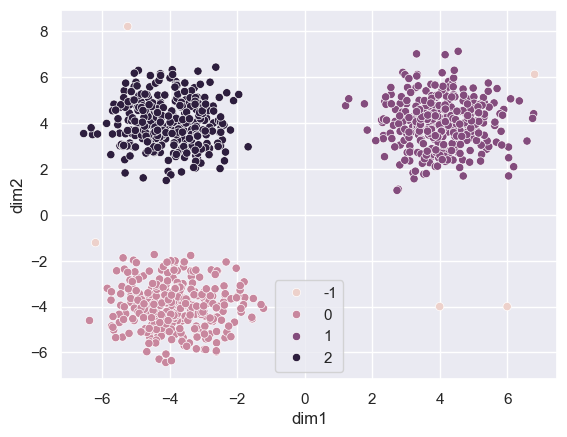

In [16]:
# Plot clustering
sns.scatterplot(X_df, x='dim1', y='dim2', hue=point_df['cluster'].to_numpy())